# CNN sa augmentacijom podataka

In [1]:
import cv2
import glob
import fnmatch
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import random

In [3]:
from keras import utils
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import AUC

### Učitavanje  putanja slika

Za učitavanje putanja do slika sa kojima radimo koristimo funkciju ***glob***. Kao argumente prosleđujemo putanje
(sa wild card karakterima koji zamenjuju bilo koje uzastopne karaktere), i parametar *recursive* koji, kada je postavljen
na *True*, omogućava da se pretrga vrši po svim direktorijumima i poddirektorijumima.

In [4]:
imagePatches = glob.glob('C:/Users/pc/Desktop/data/**/*.png', recursive=True)

Odlučili smo da radimo sa skupom od 40 000 slika.

In [5]:
imagePatches = imagePatches[:40000]

Koristimo činjenicu da svaka slika u svojoj putanji ima naznačenu klasu kojoj pripada, "class0" za 0, i "class1" za 1.

In [6]:
patternZero = '*class0.png'
patternOne = '*class1.png'

Funkcija ***fnmatch.filter*** pronalazi sve putanje koje u sebi imaju šablon koji prosleđujemo kao drugi argument. Pomoću nje delimo naše putanje u dve grupe, u zavisnosti od klase.

In [7]:
classZero = fnmatch.filter(imagePatches, patternZero) 
classOne = fnmatch.filter(imagePatches, patternOne)

Broj instanci negativne (invazivni duktalni karcinom nije detektovan) i pozitivne (invazivni duktalni karcinom je detektovan) klase:

In [8]:
print('IDC(-): {}, IDC(+): {}' .format(len(classZero), len(classOne)))

IDC(-): 30753, IDC(+): 9247


Pravimo vektor ciljnih promenljivih koji će nam biti potreban za stratifikaciju prilikom deljenja na trening i test skup.

In [9]:
y = np.zeros(len(imagePatches))
for i in range(len(imagePatches)):
    if imagePatches[i] in classOne:
        y[i] = 1

In [10]:
y = y.astype('int64')
np.bincount(y)

array([30753,  9247], dtype=int64)

### Podela podataka na train, validacioni i test skup

In [11]:
train_val_paths,test_paths,y_train_val,y_test = model_selection.train_test_split(imagePatches, y, test_size = 0.33, random_state = 42, stratify = y)

In [12]:
print('train_validation_size: {}, test_size: {} ' .format(len(train_val_paths), len(test_paths)))

train_validation_size: 26800, test_size: 13200 


In [13]:
n = np.bincount(y_train_val)
print('TrainVal skup: IDC(-): {}, IDC(+): {}' .format(n[0], n[1]))

TrainVal skup: IDC(-): 20605, IDC(+): 6195


In [14]:
n = np.bincount(y_test)
print('Test skup: IDC(-): {}, IDC(+): {}' .format(n[0], n[1]))

Test skup: IDC(-): 10148, IDC(+): 3052


##### Podela train_validation skupa

In [15]:
train_paths,val_paths,y_train,y_val = model_selection.train_test_split(train_val_paths, y_train_val, test_size = 0.2, random_state = 42, stratify = y_train_val)

In [16]:
print('train_size: {}, val_size: {}' .format(len(train_paths),len(val_paths)))

train_size: 21440, val_size: 5360


### Nebalansiranost train skupa

U train skupu imamo znatno manji broj instanci pozitivne klase.

In [17]:
n = np.bincount(y_train)
print('Train skup: IDC(-): {}, IDC(+): {}' .format(n[0], n[1]))

Train skup: IDC(-): 16484, IDC(+): 4956


Isto važi i za validacioni skup.

In [18]:
n = np.bincount(y_val)
print('Validation skup: IDC(-): {}, IDC(+): {}' .format(n[0], n[1]))

Validation skup: IDC(-): 4121, IDC(+): 1239


In [19]:
classZeroTrain = fnmatch.filter(train_paths, patternZero) 
classOneTrain = fnmatch.filter(train_paths, patternOne)

Utvrđujemo kolika je razlia između broja instanci negativne i pozitivne klase. Izdvajamo onoliko putanja do pozitivnih instanci kolika je dobijena razlika (broj n). Te putanje smeštamo u skup "additional_paths". Izdvajanje mora biti sa ponavljanjem, jer razlika između kardinalnosti klasa može biti veća od kardinalnosti manjinske klase.

In [20]:
n = len(classZeroTrain) - len(classOneTrain)
index = np.random.randint(0, len(classOneTrain), n)
classOneTrain = np.array(classOneTrain)
additional_paths = classOneTrain[index]

### Učitavanje slika

##### Train skup

In [21]:
width = 50
height = 50

In [22]:
X_train = []
y_train = list(y_train)

Učitavamo slike iz nebalansiranog train skupa:

In [23]:
for i in range(len(train_paths)):
    img = cv2.resize(cv2.imread(train_paths[i]), (width, height), interpolation=cv2.INTER_CUBIC)
    X_train.append(img)

Nakon toga, za svaku putanju iz additional_paths učitavamo sliku koju dodajemo u train_validation skup, pri tom primenjujući transformacije kao što su rotacija i prevrtanje (flip). Transformaciju koju primenjujemo biramo na slučajan način za svaku sliku, korišćenjem funkcije ***random.randint*** kojom biramo indeks iz liste transformacija:

In [24]:
rotate = [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
flip = [0, 1, -1]

for i in range(len(additional_paths)):
    img = cv2.resize(cv2.imread(additional_paths[i]), (width, height), interpolation=cv2.INTER_CUBIC)
    r = np.int(np.random.randint(0,3,1))
    f = np.int(np.random.randint(0,3,1))
    img = cv2.rotate(img, rotate[r])
    img = cv2.flip(img, flip[f])
    X_train.append(img)
    y_train.append(1)

Dodatno mešamo slike, da ne bismo na jednom mestu imali veliki broj instanci pozitivne klase koje smo naknadno dodali:

In [25]:
X_train = np.array(X_train)
index =  random.sample(list(np.arange(len(X_train))), k = len(X_train))
X_train = X_train[index]
y_train = np.array(y_train)
y_train = y_train[index]

In [26]:
X_train.shape

(32968, 50, 50, 3)

Dobili smo balansiran skup.

In [27]:
np.bincount(y_train)

array([16484, 16484], dtype=int64)

##### Validacioni skup


In [28]:
# ucitavamo slike validacionog skupa
X_val = []

for i in range(len(val_paths)):
    img = cv2.resize(cv2.imread(val_paths[i]), (width, height), interpolation=cv2.INTER_CUBIC)
    X_val.append(img)

X_val = np.array(X_val)

In [29]:
X_val.shape

(5360, 50, 50, 3)

##### Test skup


In [30]:
# ucitavamo slike test skupa
X_test = []

for i in range(len(test_paths)):
    img = cv2.resize(cv2.imread(test_paths[i]), (width, height), interpolation=cv2.INTER_CUBIC)
    X_test.append(img)
    
X_test = np.array(X_test)

In [31]:
X_test.shape

(13200, 50, 50, 3)

### Normalizacija

Svodimo vrednosti svakog piksela u opseg [0,1]

In [32]:
X_train = X_train.astype('float32')
X_train = X_train/255

In [33]:
X_val= X_val.astype('float32')
X_val = X_val/255

In [34]:
X_test = X_test.astype('float32')
X_test = X_test/255

### One-hot kodiranje ciljne promenljive

In [35]:
number_of_classes = len(np.unique(y_train))
y_train_oneHot = utils.to_categorical(y_train, number_of_classes)
y_val_oneHot = utils.to_categorical(y_val, number_of_classes)
y_test_oneHot = utils.to_categorical(y_test,number_of_classes)

### Kreiranje i treniranje mreže 

In [36]:
input_shape = (50,50,3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(number_of_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 1e-5), metrics = [AUC()])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)             

In [37]:
batch_size = 32
epochs = 30
history = model.fit(X_train, y_train_oneHot, epochs = epochs, batch_size = batch_size, validation_data = (X_val, y_val_oneHot))


Train on 32968 samples, validate on 5360 samples
Epoch 1/30
32968/32968 [==============================] - 119s 4ms/step - loss: 0.5460 - auc_1: 0.8266 - val_loss: 0.4496 - val_auc_1: 0.8807
Epoch 2/30
32968/32968 [==============================] - 118s 4ms/step - loss: 0.4514 - auc_1: 0.8727 - val_loss: 0.4086 - val_auc_1: 0.8985
Epoch 3/30
32968/32968 [==============================] - 119s 4ms/step - loss: 0.4382 - auc_1: 0.8791 - val_loss: 0.5003 - val_auc_1: 0.8357
Epoch 4/30
32968/32968 [==============================] - 135s 4ms/step - loss: 0.4323 - auc_1: 0.8824 - val_loss: 0.4363 - val_auc_1: 0.8795
Epoch 5/30
32968/32968 [==============================] - 139s 4ms/step - loss: 0.4285 - auc_1: 0.8844 - val_loss: 0.4076 - val_auc_1: 0.8982
Epoch 6/30
32968/32968 [==============================] - 144s 4ms/step - loss: 0.4255 - auc_1: 0.8863 - val_loss: 0.3934 - val_auc_1: 0.9056
Epoch 7/30
32968/32968 [==============================] - 144s 4ms/step - loss: 0.4227 - auc_1: 0.

### Evaluacija mreže

In [38]:
model.metrics_names

['loss', 'auc_1']

In [39]:
def plot(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    
    epochs = history.epoch
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    plt.title('LOSS')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(epochs,loss,c='red',label='training')
    plt.plot(epochs,validation_loss,c='blue',label='validation')
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    
    acc = history.history['auc_1']
    acc_val = history.history['val_auc_1']
    plt.title('AUC')
    plt.xlabel('epochs')
    plt.ylabel('AUC')
    plt.plot(epochs,acc,c='red',label='training')
    plt.plot(epochs,acc_val,c='blue',label='validation')
    plt.legend(loc='best')
    
    plt.show()

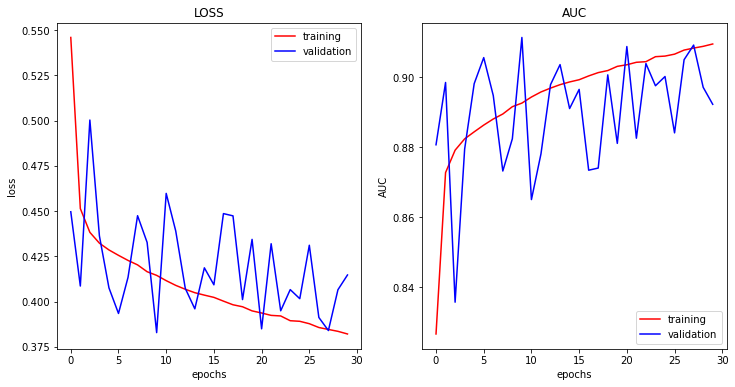

In [40]:
plot(history)

In [41]:
score_train = model.evaluate(X_train,y_train_oneHot, verbose = 0) 

In [42]:
print('loss_train:{:.2f}, auc_score_train: {:.2f}' .format(score_train[0],score_train[1]))

loss_train:0.38, auc_score_train: 0.91


In [43]:
score_test = model.evaluate(X_test,y_test_oneHot, verbose = 0)

In [44]:
print('loss_test:{:.2f}, auc_score_test: {:.2f}' .format(score_test[0],score_test[1]))

loss_test:0.42, auc_score_test: 0.89


In [45]:
y_pred = model.predict(X_test)

In [46]:
y_pred = np.argmax(y_pred, axis = 1)

In [47]:
m = confusion_matrix(y_test,y_pred)
print(m)

[[8061 2087]
 [ 404 2648]]


In [48]:
r = classification_report(y_test,y_pred)
print(r)

              precision    recall  f1-score   support

           0       0.95      0.79      0.87     10148
           1       0.56      0.87      0.68      3052

    accuracy                           0.81     13200
   macro avg       0.76      0.83      0.77     13200
weighted avg       0.86      0.81      0.82     13200



In [49]:
accuracy = metrics.accuracy_score(y_test,y_pred)
print('accuracy_score: {:.2f}' .format(accuracy))

accuracy_score: 0.81


In [50]:
f1 = metrics.f1_score(y_test,y_pred)
print('f1_score: {:.2f}' .format(f1))

f1_score: 0.68


In [51]:
auc = metrics.roc_auc_score(y_test,y_pred)
print('auc_score: {:.2f}' .format(auc))

auc_score: 0.83
